# Introduction to machine learning in molecular chemistry

Machine learning (ML) is an important tool for novel drug design. Using mathematical models to select molecules for laboratory testing allows pharma companies to save time and money, and shorten time-to-market for new drugs.

This tutorial is a short introduction to molecular property prediction, a key area in novel drug design. The goal is to create a predictive model that is able to accurately predict certain properties of molecules, based on historical experimental data. Such properties include, e.g., bioactivity, toxicity, or solubility.

## Data loading and splitting

We provided files for a dataset that we authored, [ApisTox](https://www.nature.com/articles/s41597-024-04232-w). It concerns predicting toxicity of pesticides to honey bees. Molecules are provided in standard SMILES text format, which encodes atoms (e.g. their elements), bonds, and graph structure. The task is binary classification - non-toxic (0) or toxic (1).

Such historical data is based on laboratory tests on molecules, but for new ones, we can build ML models to predict that _in silico_. This is particularly relevant for toxicity studies, which typically require killing things. For example, LD50 (median lethal dose) toxicity value is the dose required to kill half the members of a tested population.

Let's load the data and see an example entry.

In [1]:
import pandas as pd

apistox = pd.read_csv("data/apistox_full.csv")

smiles_apistox = apistox["SMILES"]
y_apistox = apistox["label"]

print(smiles_apistox[0])
print(y_apistox[0])

O=C(O)C(=O)O
0


SMILES is the standard format for storing molecules as text. To work with this data, we need to parse it as **molecular graphs**, i.e. load the actual atoms, bonds, and the compound structure. We use the [RDKit library](https://www.rdkit.org/docs/GettingStartedInPython.html) for that. Then, we can also visualize it.

Based on those structures, we need to learn the structure-label relationship with machine learning. Then, for new molecules, we want to predict the label. This is based on the idea of **molecular similarity principle** - structurally alike compounds should have similar properties.

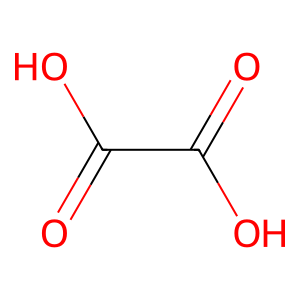

In [2]:
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import MolToImage

mol = MolFromSmiles(smiles_apistox[0])

print(mol)

MolToImage(mol)

Now to do this for all molecules, we can use the list comprehension, as shown below. However, scikit-fingerprints offers an easier way, which we will explore below.

RDKit sometimes prints a lot of warnings about hydrogens - this can be safely ignored.

In [3]:
mols_apistox = [MolFromSmiles(smiles) for smiles in smiles_apistox]

### Scikit-fingerprints API

Scikit-fingerprints is based on the scikit-learn interface (API), which primarily means:

1. Many elements (e.g. molecular fingerprints, filters) are represented as Python classes.
2. Constructor parameters control the general behavior, and act as hyperparameters in ML.
3. Primary methods are:
   - `.fit()` - learn from data, e.g. train model
   - `.transform()` - transform data, e.g. turn molecules into feature vectors
   - `.predict()` - predict for new data using trained model
4. It's fully interoperable with scikit-learn and other libraries in that ecosystem.

In scikit-fingerprints, we primarily use the `.transform()` interface to process molecules. For example, you can:
- parse SMILES as `Mol` objects
- extract features from molecules, turning `Mol` into NumPy arrays
- combine multiple vector representations
- tune hyperparameters of this process

---

Many drugs directly affect the central nervous system and brain. They need to go through the blood-brain barrier, known as BBBP property. The [BBBP dataset](https://pubs.acs.org/doi/10.1021/ci300124c), published as part of [MoleculeNet benchmark](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a), provides such data.

This dataset is built into our [scikit-fingerprints](https://scikit-fingerprints.readthedocs.io/latest/index.html) library, which we will be using for majority of the tutorial. Dataset loading functions follow scikit-learn conventions, and here we will use the [load_bbbp() function](https://scikit-fingerprints.readthedocs.io/latest/modules/datasets/generated/skfp.datasets.moleculenet.load_bbbp.html).

It returns two values:
- list of molecules in SMILES format
- labels (here 0/1, permeates blood-brain barrier or not)

**Exercise 1**

1. Load smiles strings and labels of the bbbp dataset using `load_bbbp()` function from scikit-fingerprints. Store SMILES strings as `smiles_list` and labels as `y_bbbp`
2. Import relevant class from [skfp.preprocessing module](https://scikit-fingerprints.readthedocs.io/stable/modules/preprocessing.html), using the documentation.
3. Create the object instance. You don't need to provide any arguments, but we often use `suppress_warnings`.
4. Pass the SMILES list to `.transform()` method. It returns a list of `Mol` objects. Store the resulting list in `mols` variable.
5. Display an example molecule.

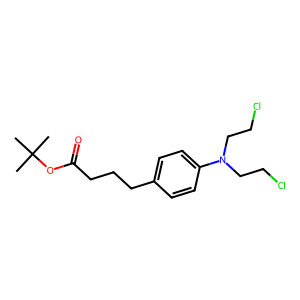

In [4]:
import pandas as pd
from skfp.datasets.moleculenet import load_bbbp
from skfp.preprocessing import MolFromSmilesTransformer

smiles_list, y_bbbp = load_bbbp()

mol_from_smiles = MolFromSmilesTransformer(suppress_warnings=True)
mols_bbbp = mol_from_smiles.transform(smiles_list)

MolToImage(mols_bbbp[1])

Great. We have an expressive molecular representation that can be processed by algorithms. Now we need a train-test set, to have data to learn from, and to test model generalization on. In novel drug design, we know that future compounds will be structurally different - we want to discover new things, after all.

Additionally, random split would overestimate the performance. This is because it can put very similar molecules in train and test set. By assumption of molecular similarity principle, they have similar properties, so that would be artificially easy. See an example:

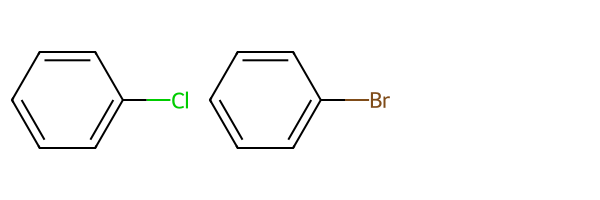

In [5]:
from rdkit.Chem.Draw import MolsToGridImage


MolsToGridImage(
    [MolFromSmiles("ClC1=CC=CC=C1"), MolFromSmiles("BrC1=CC=CC=C1")], 
    useSVG=True
)

How can we help that? One way is using **Bemis-Murcko scaffolds** for splitting ([additional materials](https://docs.chemaxon.com/display/docs/jklustor_bemis-murcko-clustering.md)). They extract a "backbone" shape of the molecule, by removing outlying atoms and functional groups. Then, we group molecules by scaffold, and the smallest groups are put in the test set. This generally ensures that train and test sets are quite different structurally.

Let's see an example of scaffolds of those two molecules from above:

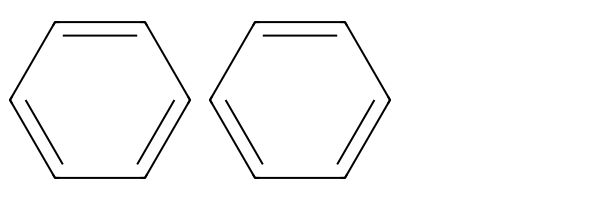

In [6]:
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol


MolsToGridImage(
    [GetScaffoldForMol(MolFromSmiles("ClC1=CC=CC=C1")), GetScaffoldForMol(MolFromSmiles("BrC1=CC=CC=C1"))], 
    useSVG=True
)

So they would be in the same group - train or test. Scikit-fingerprints provides [a few different algorithms](https://scikit-fingerprints.readthedocs.io/latest/modules/model_selection.html) for train-test splitting, including scaffold split. They are used very similar to scikit-learn random split.

For ApisTox, we also included the time split, based on literature data of pesticides, which serves a similar purpose. However, it's better suited for salts, which are disconnected graphs, for which scaffold split is not well-defined.

In [7]:
import pandas as pd


df_apistox_train = pd.read_csv("data/apistox_time_train.csv")
df_apistox_test = pd.read_csv("data/apistox_time_test.csv")

smiles_apistox_train = df_apistox_train["SMILES"]
smiles_apistox_test = df_apistox_test["SMILES"]

y_apistox_train = df_apistox_train["label"]
y_apistox_test = df_apistox_test["label"]

mol_from_smiles = MolFromSmilesTransformer(suppress_warnings=True)
mols_apistox_train = mol_from_smiles.transform(smiles_apistox_train)
mols_apistox_test = mol_from_smiles.transform(smiles_apistox_test)

**Exercise 2**

Use `scaffold_train_test_split` from scikit-fingerprints module to split the BBBP data into train and test sets, with 20% of data for testing.

Visualize an example scaffold from train and test sets.

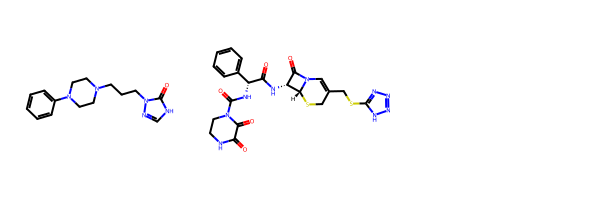

In [8]:
from skfp.model_selection import scaffold_train_test_split


mols_bbbp_train, mols_bbbp_test, y_bbbp_train, y_bbbp_test = scaffold_train_test_split(
    mols_bbbp, y_bbbp
)

MolsToGridImage(
    [GetScaffoldForMol(mols_bbbp_train[0]), GetScaffoldForMol(mols_bbbp_test[0])],
    useSVG=True,
)

## Molecular fingerprints

Nearly all predictive ML models work on fixed-size vectors, representing our data in vector space. They work under the assumption that close objects are similar, and different classes should be preferably far from each other. Molecular graphs are non-Euclidean, permutation-invariant, and vary in size, so for ML we first need feature extraction.

Molecular fingerprints are feature extraction algorithms. They transform molecular graphs to feature vectors, extracting meaningful features from the graph. They are typically based on:

1. Mathematical graph features, e.g. subgraphs, paths, walks.

2. Substructures meaningful for chemists, e.g. functional groups, rings, particular atoms.

3. Physicochemical descriptors, e.g. elements distribution, mass, charge, surface area.

In this tutorial, we focus on types 1 and 2, as more easily understandable to non-chemists. They also tend to work very well for many problems.

Let's see an example of substructure fingerprint, defined by expert chemists - MACCS Keys. It is implemented in [skfp.fingerprints module](https://scikit-fingerprints.readthedocs.io/latest/modules/fingerprints.html). Note that we can easily **parallelize** distribution to use many cores with `n_jobs` parameter (`-1` means using all cores).

In [9]:
from skfp.fingerprints import MACCSFingerprint

# create fingerprint transformer object
fp_maccs = MACCSFingerprint(n_jobs=-1)

# transform molecules into feature vectors|
X_apistox_train_maccs = fp_maccs.transform(mols_apistox_train)
X_apistox_test_maccs = fp_maccs.transform(mols_apistox_test)

print(f"Fingerprint data shape: {X_apistox_train_maccs.shape}")
print(f"Example vector: {X_apistox_train_maccs[0]}")

Fingerprint data shape: (828, 166)
Example vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0]


With this, we turned our graph classification problem into tabular classification! Now we can use any typical algorithms from scikit-learn to fit and evaluate the model. Molecular datasets are almost always imbalanced, so metrics like [AUROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) are used.

We can also compare the result with [our paper on predicting pesticides' toxicity with ApisTox](https://arxiv.org/abs/2503.24305).

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

clf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf.fit(X_apistox_train_maccs, y_apistox_train)

y_pred_proba = clf.predict_proba(X_apistox_test_maccs)[:, 1]
auroc = roc_auc_score(y_apistox_test, y_pred_proba)

print(f"AUROC: {auroc:.2%}")

AUROC: 75.24%


**Exercise 3**

[Extended Connectivity FingerPrint (ECFP)](https://docs.chemaxon.com/display/docs/fingerprints_extended-connectivity-fingerprint-ecfp.md) is arguably the most commonly used fingeprint. It uses circular neighborhoods as features, which is simple, fast, yet often gives state-of-the-art (SOTA) results.

Calculating circular neighborhoods:

<img src="images/ecfp.png" alt="Drawing" style="width: 200px;"/>

Hashing based on generated subgaphs:

<img src="images/ecfp_generation.png" alt="Drawing" style="width: 1000px;"/>

Indexing onto output vector using hashes:

<img src="images/ecfp_folding.png" alt="Drawing" style="width: 1000px;"/>

Images taken from [chemaxon](https://docs.chemaxon.com/display/docs/fingerprints_extended-connectivity-fingerprint-ecfp.md)

1. Import and calculate the ECFP fingerprint from `skfp.fingerprints`.
2. Create the fingerprint in two variants:
   - default parameters
   - with `count=True`, to count substructures, rather than just detecting them
3. Transform train and test molecules for BBBP dataset into matrices `X_bbbp_train`, `X_bbbp_test`, `X_bbbp_count_train`, `X_bbbp_count_test`.
4. Train Random Forest classifiers on both cases and make predictions for test data.
5. Compare the results on AUROC metric.

In [11]:
from skfp.fingerprints import ECFPFingerprint

# binary
fp_ecfp = ECFPFingerprint()
X_bbbp_train = fp_ecfp.transform(mols_bbbp_train)
X_bbbp_test = fp_ecfp.transform(mols_bbbp_test)

clf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf.fit(X_bbbp_train, y_bbbp_train)
y_pred_proba = clf.predict_proba(X_bbbp_test)[:, 1]

# count
fp_ecfp = ECFPFingerprint(count=True)
X_bbbp_count_train = fp_ecfp.transform(mols_bbbp_train)
X_bbbp_count_test = fp_ecfp.transform(mols_bbbp_test)

clf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf.fit(X_bbbp_count_train, y_bbbp_train)
y_pred_proba_count = clf.predict_proba(X_bbbp_count_test)[:, 1]

# comparison
auroc = roc_auc_score(y_bbbp_test, y_pred_proba)
auroc_count = roc_auc_score(y_bbbp_test, y_pred_proba_count)

print(f"Binary AUROC: {auroc:.2%}")
print(f"Count AUROC: {auroc_count:.2%}")

Binary AUROC: 84.37%
Count AUROC: 85.71%


## Distances and similarities

Molecular fingerprints are often very high-dimensional vectors and very sparse, often with >95% zero values. Euclidean distance does not work well with such data, yet we need distance measurements in ML, for example for:

- kNN classification & regression

- similarity searching

- density-based clustering, e.g. DBSCAN, HDBSCAN

- nonparametric visualization, e.g. UMAP, t-SNE

There are a lot of similarity and distance measures for **binary and count data**, and scikit-fingerprints implements them in [skfp.distances module](https://scikit-fingerprints.readthedocs.io/latest/modules/distances.html).

The most popular one is **Tanimoto similarity**, which for two binary vector is defined as intersection over union of bits:

$$
\text{sim}_{Tanimoto}(\vec{a}, \vec{b}) = \frac{|\vec{a} \cap \vec{b}|}{|\vec{a} \cup \vec{b}|}
$$

It can also be easily transformed into a distance:

$$
\text{dist}_{Tanimoto}(\vec{a}, \vec{b}) = 1 - \frac{|\vec{a} \cap \vec{b}|}{|\vec{a} \cup \vec{b}|}
$$

Further, it can be extended for count vectors:

$$
\text{sim}_{count\_Tanimoto}(\vec{a}, \vec{b}) = \frac{\vec{a} \cdot \vec{b}}{\|\vec{a}\|^2 + \|\vec{b}\|^2 - \vec{a} \cdot \vec{b}}
$$

If you're interested why Tanimoto distance is used, see e.g. ["Why is Tanimoto index an appropriate choice for fingerprint-based similarity calculations?" D. Bajusz et al.](https://doi.org/10.1186/s13321-015-0069-3)

In [12]:
from skfp.distances import tanimoto_count_distance

print(X_apistox_train_maccs[0])
print(X_apistox_train_maccs[3])

tanimoto_count_distance(X_apistox_train_maccs[0], X_apistox_train_maccs[3])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0]


0.6

**Exercise 4**

1. Import binary and count Tanimoto distance from [skfp.distances module](https://scikit-fingerprints.readthedocs.io/latest/modules/distances.html).
2. Train the kNN classifier from scikit-learn for BBBP dataset. Distance functions are passed as the `metric` argument to the class constructor. Also note that `n_jobs=-1` is very useful here. Use the ECFP fingerprints calculated above.
3. Compare AUROC between binary and count variants.

In [13]:
from skfp.distances import tanimoto_binary_distance, tanimoto_count_distance
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_jobs=-1, metric=tanimoto_binary_distance)
clf.fit(X_bbbp_train, y_bbbp_train)
y_pred_proba = clf.predict_proba(X_bbbp_test)[:, 1]
auroc = roc_auc_score(y_bbbp_test, y_pred_proba)

clf = KNeighborsClassifier(n_jobs=-1, metric=tanimoto_count_distance)
clf.fit(X_bbbp_count_train, y_bbbp_train)
y_pred_proba = clf.predict_proba(X_bbbp_count_test)[:, 1]
auroc_count = roc_auc_score(y_bbbp_test, y_pred_proba)

print(f"Binary AUROC: {auroc:.2%}")
print(f"Count AUROC: {auroc_count:.2%}")

Binary AUROC: 81.03%
Count AUROC: 79.86%


## Peptide function prediction

Peptides are small proteins, which are also therapeutic targets, similar to small compounds. We can also analyze them as molecular graphs, albeit quite large. Still, we can use molecular fingerprints, in particular count variants, that achieve state-of-the-art (SOTA) results, as we have shown in our paper ["Molecular Fingerprints Are Strong Models for Peptide Function Prediction" J. Adamczyk et al.](https://arxiv.org/abs/2501.17901)

**Exercise 5**

We will use the [dataset by Xu et al.](https://academic.oup.com/bib/article/22/5/bbab083/6189771), also known as XUAMP. The task is to predict whether a peptide has antimicrobial properties (AMP) or not. Basically the only difference from prior case is that here amino acid sequences are used instead of the SMILES format.

1. Load the XUAMP dataset from `data/xuamp_train.csv` and `data/xuamp_test.csv`.
2. Parse amino acid sequences as molecules with appropriate class from [skfp.preprocessing module](https://scikit-fingerprints.readthedocs.io/latest/modules/preprocessing.html).
3. Calculate ECFP count fingerprints.
4. Train the [LightGBM classifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html).
5. Evaluate it using AUROC.
6. Compare the results with our paper.

You can also use [scikit-learn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) for cleaner, shorter code. Scikit-fingerprints is fully integrated with its capabilities. You can provide `verbose=-1` option to `LGBMClassifier` to turn off its logs, which are pretty verbose.

In [15]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline
from skfp.preprocessing import MolFromAminoseqTransformer

df_train = pd.read_csv("data/xuamp_train.csv")
df_test = pd.read_csv("data/xuamp_test.csv")

seqs_train = df_train["sequence"]
seqs_test = df_test["sequence"]

y_train = df_train["label"]
y_test = df_test["label"]

pipeline = make_pipeline(
    MolFromAminoseqTransformer(n_jobs=-1),
    ECFPFingerprint(count=True),
    LGBMClassifier(verbose=-1, n_jobs=-1)
)
pipeline.fit(seqs_train, y_train)

y_pred = pipeline.predict_proba(seqs_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred)

print(f"AUROC: {auroc:.2%}")

AUROC: 74.84%


/home/jakub/PycharmProjects/Elements_2025_scikit-fingerprints_workshop/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
